In [1]:
%pylab inline --no-import-all
import math
import george
import numpy as np
import emcee
import scipy.optimize as op
import scipy.stats as ss
import scipy.special as ssp
from iminuit import Minuit
import ROOT as r
import corner
import matplotlib.ticker as ticker
import matplotlib.cm as cmap
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt
from george.kernels import ExpSquaredKernel


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


# Step 2: Covariances

### You'll plot a 2D map of your covariance and correlation matrices, as well as plotting individual samples from your covariance matrix vs mjj

In [21]:
def plot_cov(X, C, K, stationary=True):
    K = K 
    x = X.flatten()
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    m = ax1.imshow(C, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Correlation Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(132)
    m = ax2.imshow(np.log(K), cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax2.set_title("Log(Covariance Matrix)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("X")
    
    ax3 = fig.add_subplot(133)
    m = ax3.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax3.set_title("Covariance Matrix")
    ax3.set_xlabel("X")
    ax3.set_ylabel("X")
    


def plot_individualCov(C, K):
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    for i in range(len(K[1])):
        ax1.plot(xvalO,(K[i,:]))
    ax1.semilogy()
    ax1.set_title("Covariance vs mjj")
    
    ax2 = fig.add_subplot(132)
    ax2.semilogy()
    for i in range(len(C[1])):
        plt.plot(xvalO,C[i,:])
    ax2.set_title("Correlation vs mjj")
    
    ax3 = fig.add_subplot(133)
    ax3.plot(xvalO,(K[5,:]), c='r', label="Covariance for bin 5")
    ax3.plot(xvalO,(K[40,:]), c='g', label="Covariance for bin 40")
    ax3.plot(xvalO,(K[75,:]),c='b', label = "Covariance for bin 75")
    ax3.legend()
    ax3.semilogy()

#### Once again, make a pretty plot with multiple background realizations over data

In [3]:
def makePrettyPlots_samples(xs, ys, bkgFits, title, ymax = 2e6):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(10,10))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data")
    for ik, bkg in enumerate(bkgFits):
        if ik == 0:
            bkgPlot, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, label="Posterior samples")
        else:
            bkgPlot =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0)
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.1, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()



#### Calculate z values and chi squared goodness of fit between data and fit

In [4]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

### Grab your input data and put into arrays: in this example, I'm using the fake data I made in part 1

In [5]:
dataFileName = "inputData.root"
dataHistName = "dataset"

In [6]:
input_file = r.TFile(dataFileName, "OPEN")
input_hist = input_file.Get(dataHistName)
ycounts = []
yerrs = []
xbins = []
xerrs = []
binedges = []
for ib in range(1,input_hist.GetNbinsX()):
    ycounts.append(input_hist.GetBinContent(ib))
    yerrs.append(input_hist.GetBinError(ib))
    xbins.append(input_hist.GetBinCenter(ib))
    xerrs.append(input_hist.GetBinLowEdge(ib+1)-input_hist.GetBinLowEdge(ib))
    binedges.append(input_hist.GetBinLowEdge(ib))
input_file.Close()
ycounts = np.array(ycounts)
yerrs = np.array(yerrs)
xbins = np.array(xbins)
xerrs = np.array(xerrs)

### While you can have a mean of 0, we're going to use the 3 parameter dijet fit function as our mean. You can set it up with george like this:

In [7]:
from george.modeling import ModelingMixin
class Mean(ModelingMixin):
    def get_value(self, t):
        sqrts = 13000.
        return (self.p0 * (1.-t/sqrts)**self.p1 * (t/sqrts)**(self.p2))*np.append(np.diff(t), np.diff(t)[-1])

### Set up minuit minimization - minimize the negative log likelihood to get the kernel and mean function hyperparameters. Use built in george likelihood
### Set bounds on the hyperparameters in minuit

In [16]:
class logLike_minuit:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, length, p0, p1, p2):
        kernel = Amp*ExpSquaredKernel(length)
        gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf
        
def fit_gp_minuit(num, lnprob):
    min_likelihood = np.inf
    best_fit_params = (0, 0, 0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 100.
        init1 = np.random.random() * 20.
        init2 = np.random.random() * 1. 
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  Amp = init0, length = init1, 
                   p0 = init2, p1 = init3, p2 = init4,
                  error_Amp = 1e1, error_length = 1e1, 
                   error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (0.1, 1e10), limit_length = (100, 1e6), 
                   limit_p0 = (0,10), limit_p1 = (-20, 20), limit_p2 = (-20,20)) 
        m.migrad()
        if m.fval < min_likelihood:
            min_likelihood = m.fval
            best_fit_params = m.args 
    print "min LL", min_likelihood
    print "best fit vals", best_fit_params
    return min_likelihood, best_fit_params

### minimize our likelihood to get our hyperparameters, then call predict to get the mean predictive distribution, or our background estimation

In [17]:
lnProb = logLike_minuit(xbins, ycounts, xerrs)
min_likelihood, best_fit_gp = fit_gp_minuit(100, lnProb)
Amp, length, p0, p1, p2 = best_fit_gp
kernel = Amp*ExpSquaredKernel(length)
gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
gp.compute(xbins, yerrs)
meanGP, covGP = gp.predict(ycounts, xbins)

min LL 290.378957349
best fit vals (2.12541372560567, 309104.099907482, 0.0030575502204821525, 8.43201656031479, -6.2349591436993546)


#### draw from the posterior, create a matrix from the samples, and calculate the correlation and covariance matrices

In [23]:
samps = gp.sample_conditional(ycounts, xbins, 1000)

In [24]:
modelMatrix=np.empty([samps.shape[0], xbins.size])
for ip, ps in enumerate(samps):
    modelMatrix[ip,:]= samps[ip,:]
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log


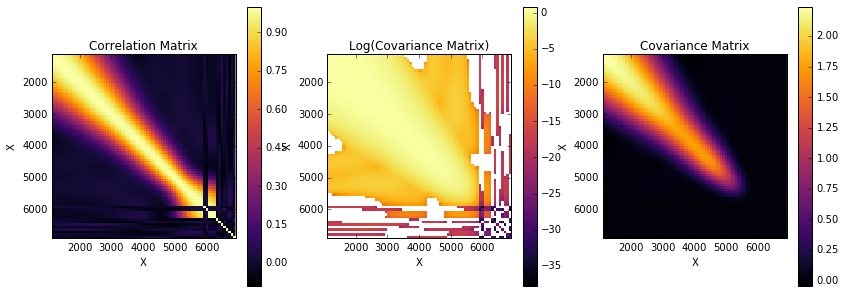

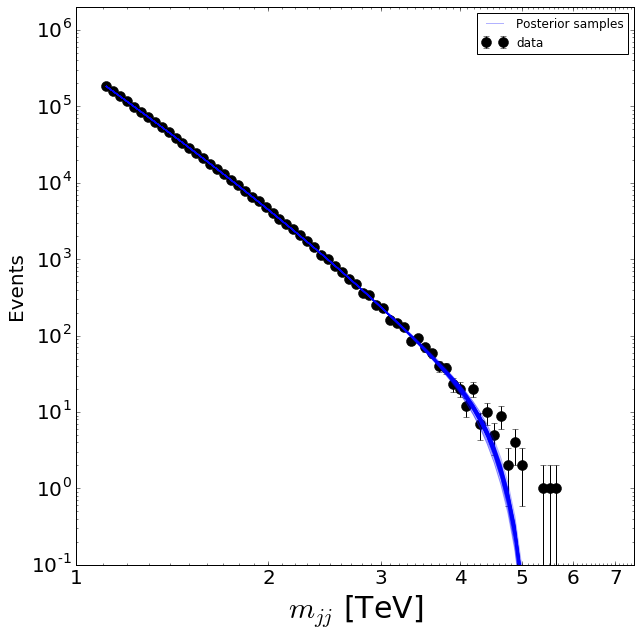

In [25]:
plot_cov(xbins, corMat, covMat, False)
makePrettyPlots_samples(xbins, ycounts, (modelMatrix[:100]).tolist(), "", ymax = 2e6)